# Develop GPU-based HIO algorithm

In [1]:
from IPython.core.display import display, HTML
import numpy as np
import numpy.fft as fft
import skimage.measure as sm
import matplotlib.pyplot as plt
from math import pi
import imageio
from numba import cuda
import numpy
import math
import time

display(HTML("<style>.container { width:95% !important; }</style>"))

# Load the test image

The image size is 217 by 163


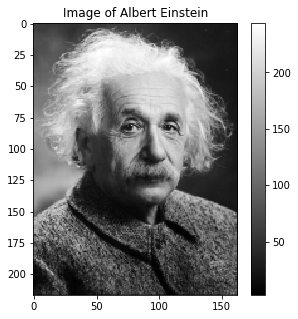

In [2]:
#Read in source image
source = plt.imread("../tests/samples/Albert_Einstein.jpg",format="jpg")

# Because the original image is too large downsample the image by a factor of 20
source = sm.block_reduce(source, (20,20), np.mean)

#Show this figure
fig = plt.figure(figsize=(5,5))
plt.imshow(source, cmap = "gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(source.shape[0], source.shape[1]))

# Simulate over-sampling

The image size is 651 by 597


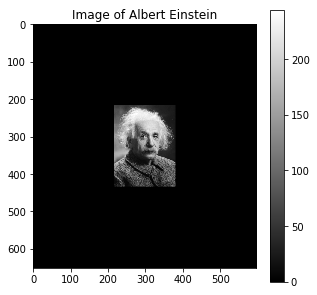

In [3]:
## pad_len is the size of the support
pad_len = len(source)
padded = np.pad(source, ((pad_len, pad_len),(pad_len, pad_len)), 'constant', 
                constant_values=((0,0),(0,0)))

#Show this figure
fig = plt.figure(figsize=(5,5))
plt.imshow(padded, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(padded.shape[0], padded.shape[1]))

The image size is 651 by 597


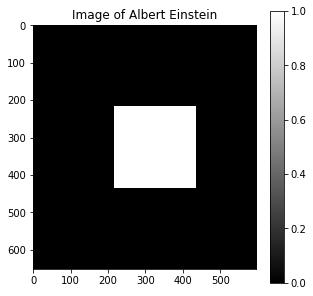

In [4]:
# Calculate the fourier transformation
ft = fft.fft2(padded)

#simulate diffraction pattern
magnitude = np.abs(ft)

length, width = padded.shape

#keep track of where the image is vs the padding
mask = np.zeros_like(padded, dtype=np.int64)
mask[pad_len:2*pad_len, pad_len:2*pad_len] = 1
#Show this mask
fig = plt.figure(figsize=(5,5))
plt.imshow(mask, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(mask.shape[0], mask.shape[1]))

diffract = np.copy(magnitude)

In [5]:
tic = time.time()

#Initial guess using random phase info
guess = diffract * np.exp(1j * np.random.rand(length,width) * 2 * pi)

inv = fft.ifft2(guess)
inv = np.real(inv)
prev = np.copy(inv)

#number of iterations
r = 801

#step size parameter
beta = 0.8

# Begin the loop
for s in range(1,r):
    #apply fourier domain constraints
    update = diffract * np.exp(1j * np.angle(guess)) 
    
    inv = fft.ifft2(update)
    inv = np.real(inv)
    
    ## This part need to be vectorize
    inv[(inv<0)&(mask==1)] = prev[(inv<0)&(mask==1)] - beta* inv[(inv<0)&(mask==1)]
    inv[mask==0] = prev[mask ==0 ] - beta*inv[mask ==0]
        
    prev = inv
    
    guess = fft.fft2(inv)
    
toc = time.time()
print("It takes {:.2f} seconds to do {} iterations.".format(toc - tic, r))

It takes 43.09 seconds to do 801 iterations.


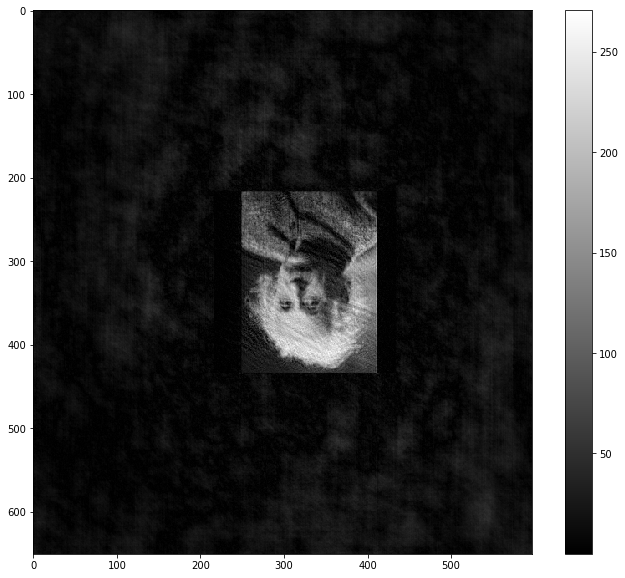

In [6]:
plt.figure(figsize=(12,10))

plt.imshow(np.abs(prev),cmap='gray')
plt.colorbar()
plt.show()